# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

## Откройте файл с данными и изучите общую информацию. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


   total_images  last_price  total_area first_day_exposition  rooms  \
0            20  13000000.0       108.0  2019-03-07T00:00:00      3   
1             7   3350000.0        40.4  2018-12-04T00:00:00      1   
2            10   5196000.0        56.0  2015-08-20T00:00:00      2   
3             0  64900000.0       159.0  2015-07-24T00:00:00      3   
4             2  10000000.0       100.0  2018-06-19T00:00:00      2   

   ceiling_height  floors_total  living_area  floor is_apartment  ...  \
0            2.70          16.0         51.0      8          NaN  ...   
1             NaN          11.0         18.6      1          NaN  ...   
2             NaN           5.0         34.3      4          NaN  ...   
3             NaN          14.0          NaN      9          NaN  ...   
4            3.03          14.0         32.0     13          NaN  ...   

   kitchen_area  balcony    locality_name  airports_nearest  \
0          25.0      NaN  Санкт-Петербург           18863.0   
1       

None

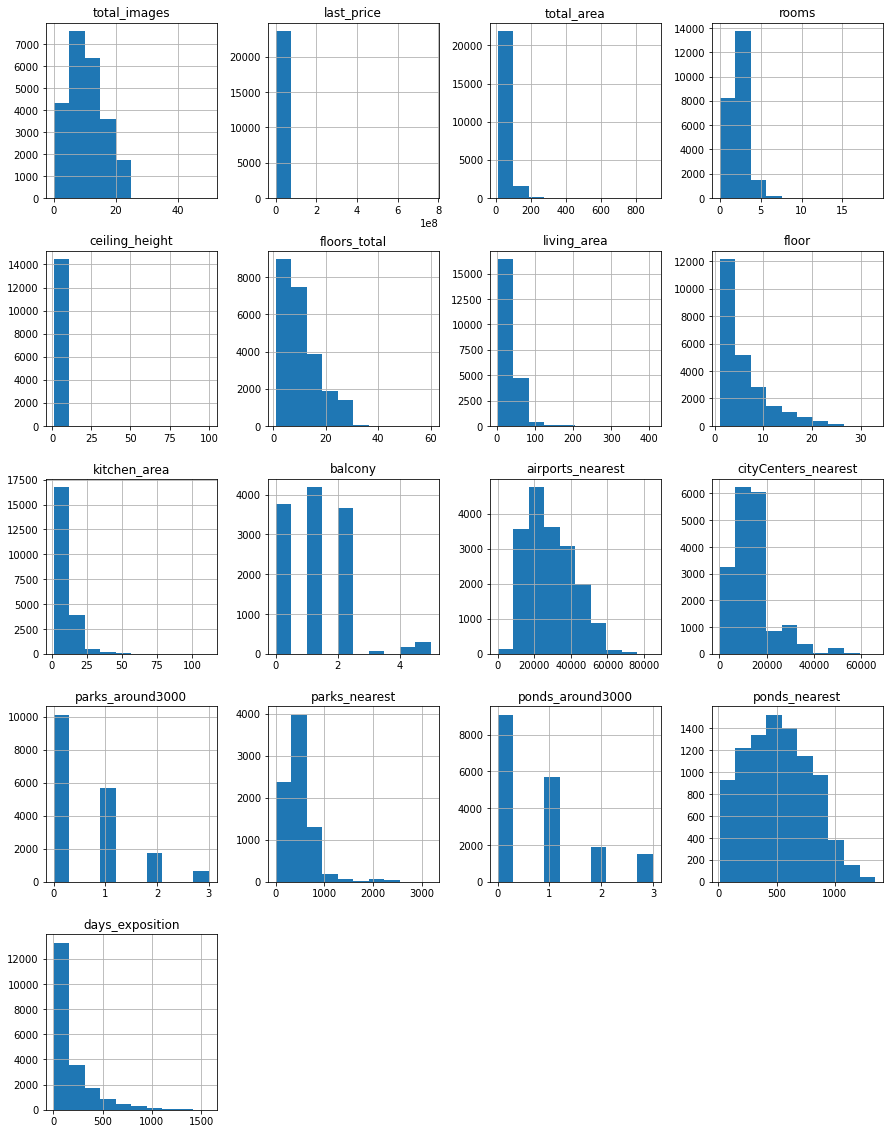

In [2]:
data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
print(data.head())

# Изучение общей информации о датафрейме
display(data.info())

# Построение общей гистограммы для всех числовых столбцов
data.hist(figsize=(15, 20));

<font size="+2">Описание данных:</font>  
**airports_nearest** — расстояние до ближайшего аэропорта в метрах (м)  
**balcony** — число балконов  
**ceiling_height** — высота потолков (м)  
**cityCenters_nearest** — расстояние до центра города (м)  
**days_exposition** — сколько дней было размещено объявление (от публикации до снятия)  
**first_day_exposition** — дата публикации  
**floor** — этаж  
**floors_total** — всего этажей в доме  
**is_apartment** — апартаменты (булев тип)  
**kitchen_area** — площадь кухни в квадратных метрах (м²)  
**last_price** — цена на момент снятия с публикации  
**living_area** — жилая площадь в квадратных метрах (м²)  
**locality_name** — название населённого пункта  
**open_plan** — свободная планировка (булев тип)  
**parks_around3000** — число парков в радиусе 3 км  
**parks_nearest** — расстояние до ближайшего парка (м)  
**ponds_around3000** — число водоёмов в радиусе 3 км  
**ponds_nearest** — расстояние до ближайшего водоёма (м)  
**rooms** — число комнат  
**studio** — квартира-студия (булев тип)  
**total_area** — общая площадь квартиры в квадратных метрах (м²)  
**total_images** — число фотографий квартиры в объявлении 

### Предобработка данных

<font size="+2">Работа с пропусками:</font>  

In [3]:
# Подсчёт количества пропусков
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

<font size="+1">Вывод:</font>  
Всего в датафрейме 22 столбца, 14 из которых имеют пропуски

Рассмотрим подробнее:  
1)**ceiling_height** — примерно в 37% объявлений отсутствует информация о высоте потолков, можно заменить их медианными значениями, в зависимости от населённого пункта   
2)**floors_total** — пропусков мало, на результат не повлияют.  
3)**living_area** — важные данные, пропусков немного, поэтому оставим столбец без изменений.    
4)**is_apartment** — тип недвижимости, пропуски можно заменить на False.    
5)**kitchen_area** — возможно, это квартира-студия, необходимо проверить.  
6)**balcony** — пропуски заменим на 0.  
7)**locality_name** — вероятно, данные просто не заполнили, данные нужны для дальнейшей работы, объвления с пропущенными значениями удалим.
8)**airports_nearest** — аэропортов рядом нет, пропуски оставляем.  
9)**cityCenters_nearest** — далеко от центра, пропуски оставляем.  
10)**parks_around3000** — парков в радиусе 3км нет, пропуски оставляем.  
11)**parks_nearest** — парков рядом нет, пропуски оставляем.  
12)**ponds_nearest** — водоёмов рядом нет, пропуски оставляем.  
13)**ponds_around3000** — водоёмы в радиусе 3 км отсутствуют.  
14)**days_exposition** — пропуски означают, что объявление не было опубликовано, пропуски оставляем.  

In [4]:
# Заполним пропущенные значения в столбце is_apartment.
data['is_apartment'] = data['is_apartment'].fillna(False)

# Заполним пропущенные значения в столбце balcony.
data['balcony'] = data['balcony'].fillna(0)

# Заполним пропуски по высоте потолков медианным значением относительно населенных пунктов.
for locality in data['locality_name'].unique():
    median_value = data.loc[data['locality_name'] == locality, 'ceiling_height'].median()
    data.loc[(data['ceiling_height'].isna()) & (data['locality_name'] == locality), 'ceiling_height'].median()

data.loc[data['ceiling_height'].isna(), 'ceiling_height'] = data['ceiling_height'].median()

# Удалим объявления без указанных населённых пунктов
data['locality_name'].dropna(inplace=True)


/opt/conda/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/conda/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/conda/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/conda/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/conda/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/conda/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/conda/lib/p

<font size="+2">Изменение типов данных:</font>  

1)В столбце **last_price** видно, что все данные целочисленные, изменяем тип на int64.  
2)В столбце **first_day_exposition** укажем тип datatime.  
3)В столбце **is_apartment** укажем булевый тип boolean  
4)В столбце **balcony** укажем целочисленный тип, int 64.  


In [5]:
data['last_price'] = data['last_price'].astype('int64')
data['balcony'] = data['balcony'].astype('int64')
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')
data['is_apartment'] = data['is_apartment'].astype('boolean')


# Проверка
data.dtypes

total_images                     int64
last_price                       int64
total_area                     float64
first_day_exposition    datetime64[ns]
rooms                            int64
ceiling_height                 float64
floors_total                   float64
living_area                    float64
floor                            int64
is_apartment                   boolean
studio                            bool
open_plan                         bool
kitchen_area                   float64
balcony                          int64
locality_name                   object
airports_nearest               float64
cityCenters_nearest            float64
parks_around3000               float64
parks_nearest                  float64
ponds_around3000               float64
ponds_nearest                  float64
days_exposition                float64
dtype: object

<font size="+2">Обработка дубликатов:</font>  

In [6]:
data.duplicated().sum()

0

Явные дубликаты отсутствуют, посмотрим неявные

In [7]:
# Вывод уникальных значений locality_name (населённые пункты)
data['locality_name'].sort_values().unique()

array(['Бокситогорск', 'Волосово', 'Волхов', 'Всеволожск', 'Выборг',
       'Высоцк', 'Гатчина', 'Зеленогорск', 'Ивангород', 'Каменногорск',
       'Кингисепп', 'Кириши', 'Кировск', 'Колпино', 'Коммунар',
       'Красное Село', 'Кронштадт', 'Кудрово', 'Лодейное Поле',
       'Ломоносов', 'Луга', 'Любань', 'Мурино', 'Никольское',
       'Новая Ладога', 'Отрадное', 'Павловск', 'Петергоф', 'Пикалёво',
       'Подпорожье', 'Приморск', 'Приозерск', 'Пушкин', 'Санкт-Петербург',
       'Светогорск', 'Сертолово', 'Сестрорецк', 'Сланцы', 'Сосновый Бор',
       'Сясьстрой', 'Тихвин', 'Тосно', 'Шлиссельбург',
       'городской поселок Большая Ижора', 'городской поселок Янино-1',
       'городской посёлок Будогощь', 'городской посёлок Виллози',
       'городской посёлок Лесогорский', 'городской посёлок Мга',
       'городской посёлок Назия', 'городской посёлок Новоселье',
       'городской посёлок Павлово', 'городской посёлок Рощино',
       'городской посёлок Свирьстрой', 'городской посёлок Совет

In [8]:
print(data['locality_name'].sort_values().unique())

# Заменяем все буквы"ё" на "е"
data['locality_name'] = data['locality_name'].str.replace('ё', 'е')

# Заменяем городской поселок на поселок городского типа
data['locality_name'] = data['locality_name'].str.replace('городской поселок','поселок городского типа')



['Бокситогорск' 'Волосово' 'Волхов' 'Всеволожск' 'Выборг' 'Высоцк'
 'Гатчина' 'Зеленогорск' 'Ивангород' 'Каменногорск' 'Кингисепп' 'Кириши'
 'Кировск' 'Колпино' 'Коммунар' 'Красное Село' 'Кронштадт' 'Кудрово'
 'Лодейное Поле' 'Ломоносов' 'Луга' 'Любань' 'Мурино' 'Никольское'
 'Новая Ладога' 'Отрадное' 'Павловск' 'Петергоф' 'Пикалёво' 'Подпорожье'
 'Приморск' 'Приозерск' 'Пушкин' 'Санкт-Петербург' 'Светогорск'
 'Сертолово' 'Сестрорецк' 'Сланцы' 'Сосновый Бор' 'Сясьстрой' 'Тихвин'
 'Тосно' 'Шлиссельбург' 'городской поселок Большая Ижора'
 'городской поселок Янино-1' 'городской посёлок Будогощь'
 'городской посёлок Виллози' 'городской посёлок Лесогорский'
 'городской посёлок Мга' 'городской посёлок Назия'
 'городской посёлок Новоселье' 'городской посёлок Павлово'
 'городской посёлок Рощино' 'городской посёлок Свирьстрой'
 'городской посёлок Советский' 'городской посёлок Фёдоровское'
 'городской посёлок Янино-1' 'деревня Агалатово' 'деревня Аро'
 'деревня Батово' 'деревня Бегуницы' 'деревн

<font size="+2">Работа с выбросами данных:</font>  

In [9]:
# Изучим распределение значений в данных
data.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,23699.000000,2.369900e+04,23699.000000,23699.000000,23699.000000,23613.000000,21796.000000,23699.000000,21421.000000,23699.000000,18157.000000,18180.000000,18181.000000,8079.000000,18181.000000,9110.000000,20518.000000
mean,9.858475,6.541549e+06,60.348651,2.070636,2.724358,10.673824,34.457852,5.892358,10.569807,0.591080,28793.672193,14191.277833,0.611408,490.804555,0.770255,517.980900,180.888634
std,5.682529,1.088701e+07,35.654083,1.078405,0.988298,6.597173,22.030445,4.885249,5.905438,0.959298,12630.880622,8608.386210,0.802074,342.317995,0.938346,277.720643,219.727988
min,0.000000,1.219000e+04,12.000000,0.000000,1.000000,1.000000,2.000000,1.000000,1.300000,0.000000,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000,1.000000
25%,6.000000,3.400000e+06,40.000000,1.000000,2.600000,5.000000,18.600000,2.000000,7.000000,0.000000,18585.000000,9238.000000,0.000000,288.000000,0.000000,294.000000,45.000000
50%,9.000000,4.650000e+06,52.000000,2.000000,2.650000,9.000000,30.000000,4.000000,9.100000,0.000000,26726.000000,13098.500000,0.000000,455.000000,1.000000,502.000000,95.000000
75%,14.000000,6.800000e+06,69.900000,3.000000,2.700000,16.000000,42.300000,8.000000,12.000000,1.000000,37273.000000,16293.000000,1.000000,612.000000,1.000000,729.000000,232.000000
max,50.000000,7.630000e+08,900.000000,19.000000,100.000000,60.000000,409.700000,33.000000,112.000000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000


Мы можем предположить, что квартиры с высотой потолков 25-36м на самом деле являются опечаткой и соотвествуют 2.5-3.6м. Минимальная высота потолков - 1 метр, а максимальная - 100 метров, здесь явно ошибка.

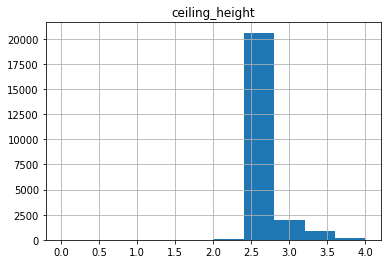

In [10]:
# Разделим значения больше 20м на 10, чтобы получить значения для нашей таблицы
data.loc[data['ceiling_height'] >= 20, 'ceiling_height'] = data['ceiling_height'] / 10

# Для наглядности построим гистрограмму
data.hist('ceiling_height',bins=10,range=(0,4));


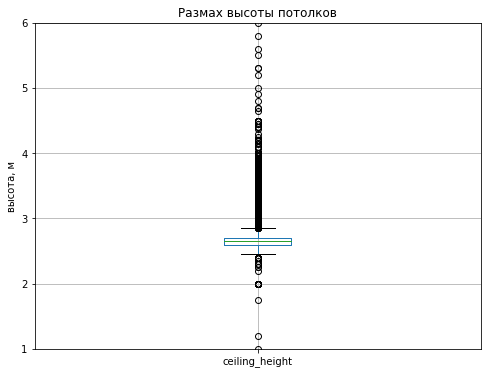

In [11]:
# Построим диаграмму размаха для высоты потолков
data.boxplot(column='ceiling_height', figsize=(8, 6))
plt.title('Размах высоты потолков')
plt.ylim(1, 6)
plt.ylabel('высота, м')
plt.show()

Будем считать, что значения меньше 2.5м и выше 2.8 - выбросы. Оставим объявления, где высота потолков от 2.5 до 5 метров.

In [12]:
data = data.query('2.5 <= ceiling_height <= 5')

# Проверка
data['ceiling_height'].max()

5.0

Также необходимо проверить значения жилой площади.

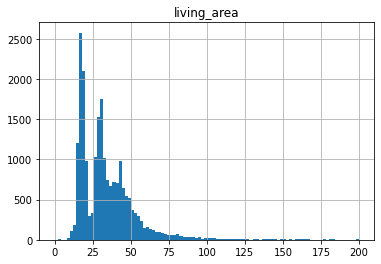

In [13]:
data.hist('living_area',bins=100, range=(0,200));

In [14]:
# Отбросим объявления с площадями квартир менее 10 и более 200 метров

data.drop(index=data.query('living_area < 10').index,inplace=True)
data.drop(index=data.query('living_area > 200').index,inplace=True)

<font size="+1">Вывод:</font>  
1) Обработали пропуски в столбцах is_apartment, balcony, ceiling_height. Удалили пропуски в столбце locality_name.
2) Изменили типы данных в стобцах last_price, first_day_exposition, is_apartment, balcony.
3) Явных дубликатов в данных нет, при работе с явными дубликатами заменили все буквы"ё" на "е", городской поселок на поселок городского типа.

### Посчитайте и добавьте в таблицу новые столбцы

In [15]:
# Добавим столбец с ценой за 1м²
data['price_one_square_meter'] = data['last_price'] / data['total_area']

# Добавим столбец с днём публикации объявления. 0 - понедельник, 1 - вторник и т.д.

data['day'] = data['first_day_exposition'].dt.dayofweek

# Добавим столбец с месяцем публикации объявления
data['month'] = data['first_day_exposition'].dt.month

# Добавим столбец с годом публикации объявления
data['year'] = data['first_day_exposition'].dt.year

# Функция для категоризации этажности в доме
def get_floor_category(row):
    floor = row['floor']
    floors_total = row['floors_total']
    if floor == 1:
        return 'первый'
    elif floor == floors_total:
        return 'последний'
    else:
        return 'другой'
    
# Добавляем столбец с типом этажа квартиры
data['floor_category'] = data.apply(get_floor_category, axis=1)

# Добавляем столбец с расстоянием до центра
data['cityCenters_nearest'] = round(data['cityCenters_nearest'] / 1000)

# Выполним проверку
data.head(5)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_one_square_meter,day,month,year,floor_category
0,20,13000000,108.0,2019-03-07,3,2.70,16.0,51.0,8,False,...,1.0,482.0,2.0,755.0,NaN,120370.370370,3,3,2019,другой
1,7,3350000,40.4,2018-12-04,1,2.65,11.0,18.6,1,False,...,0.0,NaN,0.0,NaN,81.0,82920.792079,1,12,2018,первый
2,10,5196000,56.0,2015-08-20,2,2.65,5.0,34.3,4,False,...,1.0,90.0,2.0,574.0,558.0,92785.714286,3,8,2015,другой
3,0,64900000,159.0,2015-07-24,3,2.65,14.0,NaN,9,False,...,2.0,84.0,3.0,234.0,424.0,408176.100629,4,7,2015,другой
4,2,10000000,100.0,2018-06-19,2,3.03,14.0,32.0,13,False,...,2.0,112.0,1.0,48.0,121.0,100000.000000,1,6,2018,другой


### Проведите исследовательский анализ данных

count    23553.000000
mean        59.878901
std         32.617651
min         12.000000
25%         40.000000
50%         52.000000
75%         69.740000
max        631.000000
Name: total_area, dtype: float64

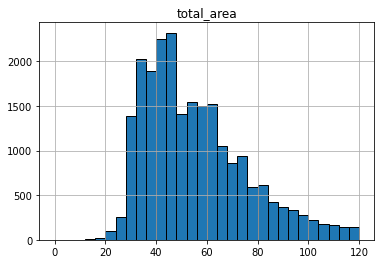

In [16]:
# Построим гистограмму по столбцу "Общая площадь квартиры в квадратных метрах (м²)"
data.hist('total_area', bins=30, range=(0,120),ec='black');
data['total_area'].describe().T

Большая часть квартир имеет площадь примерно 40-45 км.м. Квартиры c площадью более 100 кв.м. встречаются редко, как и квартиры площадью менее 30 кв.м.

count    21658.000000
mean        34.151069
std         20.075212
min         10.000000
25%         18.600000
50%         30.000000
75%         42.300000
max        200.000000
Name: living_area, dtype: float64

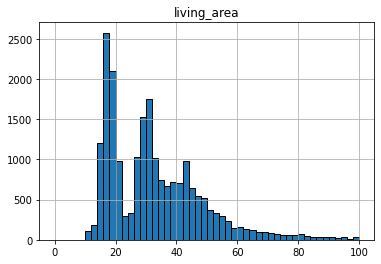

In [17]:
# Построим гистограмму по столбцу "Жилая площадь в квадратных метрах (м²)"
data.hist('living_area', bins=50,range=(0,100), ec='black');
data['living_area'].describe().T

Большая часть квартир имеет жилую площадь от 15 до 35 кв.м. Самый распространённый вариант - около 15 кв.м. Квартиры с жилой площадью более 60 кв.м. встречаются редко.

count    21292.000000
mean        10.524726
std          5.719312
min          1.300000
25%          7.000000
50%          9.100000
75%         12.000000
max        107.000000
Name: kitchen_area, dtype: float64

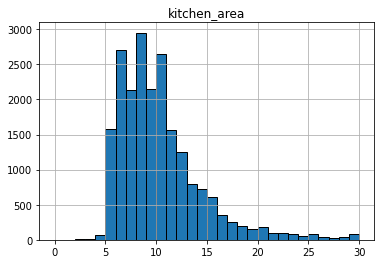

In [18]:
# Построим гистограмму по столбцу "Площадь кухни в квадратных метрах (м²)"
data.hist('kitchen_area', bins=30,range=(0,30), ec='black');
data['kitchen_area'].describe().T

Большая часть квартир имеет кухню площадью от 6 до 11 кв.м. Площадь кухни более 15 кв.м. встречается редко, крайне редко встречаются кухни площадью менее 5 кв.м.

count    23553.000000
mean         6.370573
std          8.132521
min          0.012190
25%          3.420000
50%          4.650000
75%          6.790000
max        330.000000
Name: last_price, dtype: float64

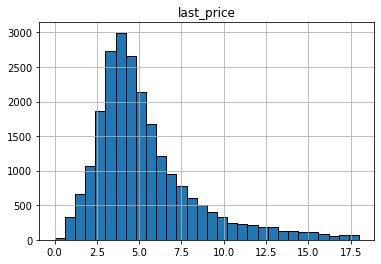

In [19]:
# Построим гистограмму по столбцу "Цена на момент снятия с публикации"
data['last_price'] = data['last_price'] / 1e6
data.hist('last_price', bins=30, range=(0, 18),ec='black');
data['last_price'].describe().T

Большая часть квартир продаётся за стоимость в пределах 3-5 млн.рублей, примерно 3.5 млн - самый популярный вариант. Количество квартир со стоимостью более 10 млн рублей заметно уменьшается. Недвижимость стоимостью менее 2.5 млн рублей встречается также редко.

count    23553.000000
mean         2.064111
std          1.054260
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         16.000000
Name: rooms, dtype: float64

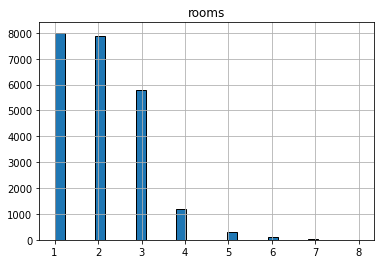

In [20]:
# Построим гистограмму по столбцу "Число комнат"
data.hist('rooms', bins=30,range=(1,8), ec='black');
data['rooms'].describe().T


Рассматриваемый диапазон - от 1 до 8 комнат, чтобы исключить нулевые (некорректные) значения. В большей части квартир от 1 до 3 комнат. Квартиры с 4 и более комнатами встречаются редко. По распределению видно, что в данных присутствует объект недвижимости с 16-тью комнатами, но на средний показатель это не влияет.

count    23553.000000
mean         2.696287
std          0.212870
min          2.500000
25%          2.600000
50%          2.650000
75%          2.700000
max          5.000000
Name: ceiling_height, dtype: float64

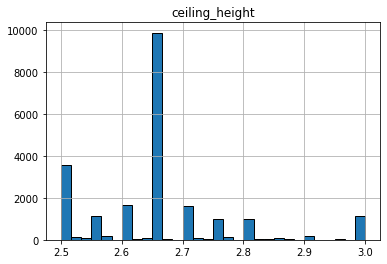

In [21]:
# Построим гистограмму по столбцу "Число комнат"
data.hist('ceiling_height', bins=30,range=(2.5,3), ec='black');
data['ceiling_height'].describe().T


Большинство квартир имеют высоту потолков 2,5 м и 2,65 м. Варианты с высотой потолков выше 2.65 м встречаются значительно реже.

count    23553.000000
mean         5.894748
std          4.887639
min          1.000000
25%          2.000000
50%          4.000000
75%          8.000000
max         33.000000
Name: floor, dtype: float64

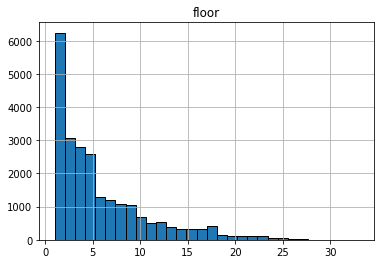

In [22]:
# Построим гистограмму по столбцу "Этаж"
data.hist('floor', bins=30,range=(1,33), ec='black');
data['floor'].describe().T

Большинство квартир расположено на 1 этаже, примерно одинаковое количество квартир расположено на 2-5 этаже - в Петербурге большинство зданий пятиэтажные. Квартиры выше 10 этажа встречаются крайне редко.

<AxesSubplot:>

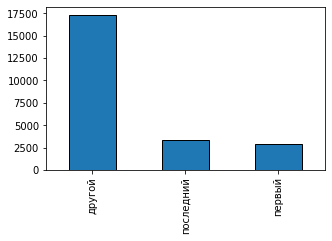

In [23]:
# Построим гистограмму по столбцу "Тип этажа квартиры («первый», «последний», «другой»)"
data['floor_category'].value_counts().plot.bar(figsize=(5, 3), ec='black')

В основном квартиры расположенны на этажах между первым и последним. На первом и последнем этаже примерно одинаковое количество объявлений.

count    23467.000000
mean        10.686411
std          6.598981
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64

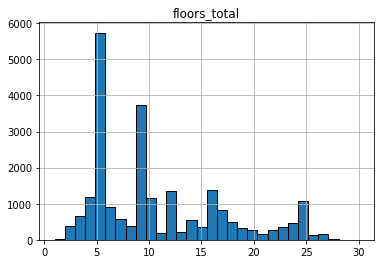

In [24]:
# Построим гистограмму по столбцу "Всего этажей в доме"

data.hist('floors_total', bins=30,range=(1,30), ec='black');
data['floors_total'].describe().T

Большинство зданий - 5-ти и 9-ти этажные. Зданий ниже 5 и выше 9 этажа значительно меньше остальных. Данные правдивы, в Петербурге действительно много 5-ти этажных и 9-ти этажных жилых домов.

count    18068.000000
mean        14.200908
std          8.617107
min          0.000000
25%          9.000000
50%         13.000000
75%         16.000000
max         66.000000
Name: cityCenters_nearest, dtype: float64

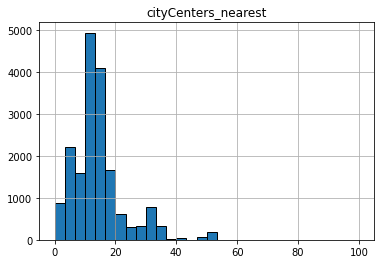

In [25]:
# Построим гистограмму по столбцу "Расстояние до центра города (м)"
data.hist('cityCenters_nearest', bins=30,range=(0,100), ec='black');
data['cityCenters_nearest'].describe().T

Большинство квартир расположено на расстоянии от 12.5 до 15 км от центра города. Квартир, которые расположены близко к центру (до 3 км) значительно меньше.

count    18046.000000
mean     28804.239554
std      12642.634863
min       6450.000000
25%      18574.000000
50%      26751.000000
75%      37310.000000
max      84869.000000
Name: airports_nearest, dtype: float64

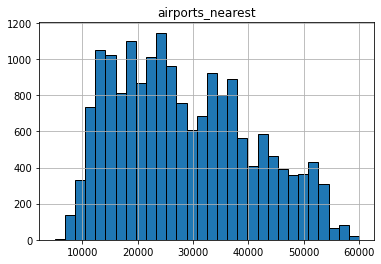

In [26]:
# Уберем нулевые значения
data = data.query('airports_nearest != 0')

# Построим гистограмму по столбцу "Расстояние до ближайшего аэропорта в метрах (м)" 
data.hist('airports_nearest', bins=30,range=(5000,60000), ec='black');
data['airports_nearest'].describe()



Большинство квартир расположены от аэропорта на расстоянии 15-25 км. Ближайший к аэропорту объект на расстоянии 6,5 км.

count    8007.000000
mean      491.044711
std       342.792729
min         1.000000
25%       288.000000
50%       454.000000
75%       612.000000
max      3190.000000
Name: parks_nearest, dtype: float64

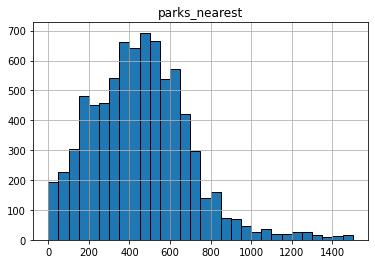

In [27]:
# Построим гистограмму по столбцу "Расстояние до ближайшего парка (м)"
data.hist('parks_nearest', bins=30,range=(0,1500), ec='black');
data['parks_nearest'].describe()

Большинство квартир расположены от парка на расстоянии 400-600 метров. Квартир с парком в радиусе 1 км очень мало. 

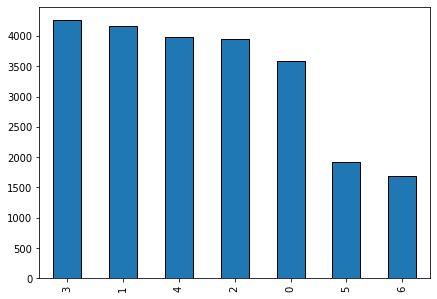

In [28]:
# Построим гистограмму по столбцу "День публикации объявления"
data['day'].value_counts().plot.bar(figsize=(7, 5), ec='black')
plt.show()


Объявления чаще всего публикуются в середине и начале недели. В выходные дни объявления публикуются реже.

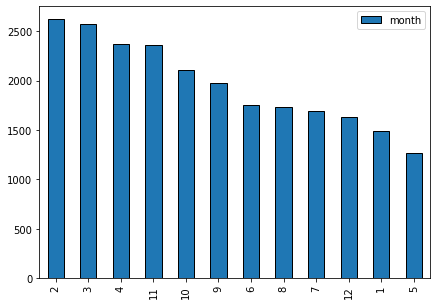

In [29]:
# Построим гистограмму по столбцу "Месяц публикации объявления"

data['month'].value_counts().plot.bar(figsize=(7, 5), ec='black', legend=True)
plt.show()

По графику видно, что чаще всего объявления публикуются в февраля, вероятно, это связано с новогодними праздниками, так как в январе объявлений значительно меньше. Февраль, март и апрель - самые крупные месяцы по количеству объявлений.

<font size="+1">Изучите, как быстро продавались квартиры (столбец days_exposition)</font>  

Среднее время продажи квартиры: 180
Медианное время продажи квартиры: 95


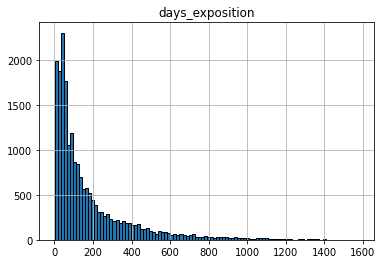

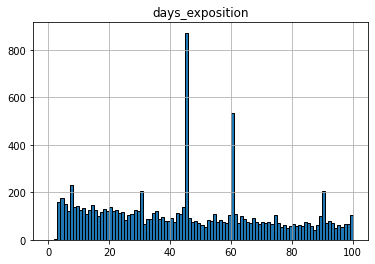

In [30]:
data.hist('days_exposition', bins=100, ec='black');
data.hist('days_exposition', bins=100, range=(0,100), ec='black');
print(f'Среднее время продажи квартиры:',int(data['days_exposition'].mean()))
print('Медианное время продажи квартиры:',int(data['days_exposition'].median()))

Среднее время продажи квартиры - 180 дней, медианное время - 95. Я бы предположил, что быстрая продажа квартиры - это менее 95 дней, а долгая - свыше 180 дней. 

Квартир, которые продаются более 100 дней значительно меньше, чем всех остальных, поэтому второй график я ограничил до 100 дней.

На втором графике видно, что большинство квартир продаются за 45 дней, либо за 60. Вероятно, долгие продажи связаны с тем, что объявления просто не убрали с сайтов.

<font size="+1">Какие факторы больше всего влияют на общую (полную) стоимость объекта</font>  

                       last_price  total_area  living_area  kitchen_area  \
last_price               1.000000    0.692498     0.591556      0.523137   
total_area               0.692498    1.000000     0.932625      0.592209   
living_area              0.591556    0.932625     1.000000      0.387955   
kitchen_area             0.523137    0.592209     0.387955      1.000000   
rooms                    0.395857    0.767429     0.863055      0.244040   
floor_category_number    0.064862    0.017122    -0.019648      0.098675   

                          rooms  floor_category_number  
last_price             0.395857               0.064862  
total_area             0.767429               0.017122  
living_area            0.863055              -0.019648  
kitchen_area           0.244040               0.098675  
rooms                  1.000000              -0.057513  
floor_category_number -0.057513               1.000000  


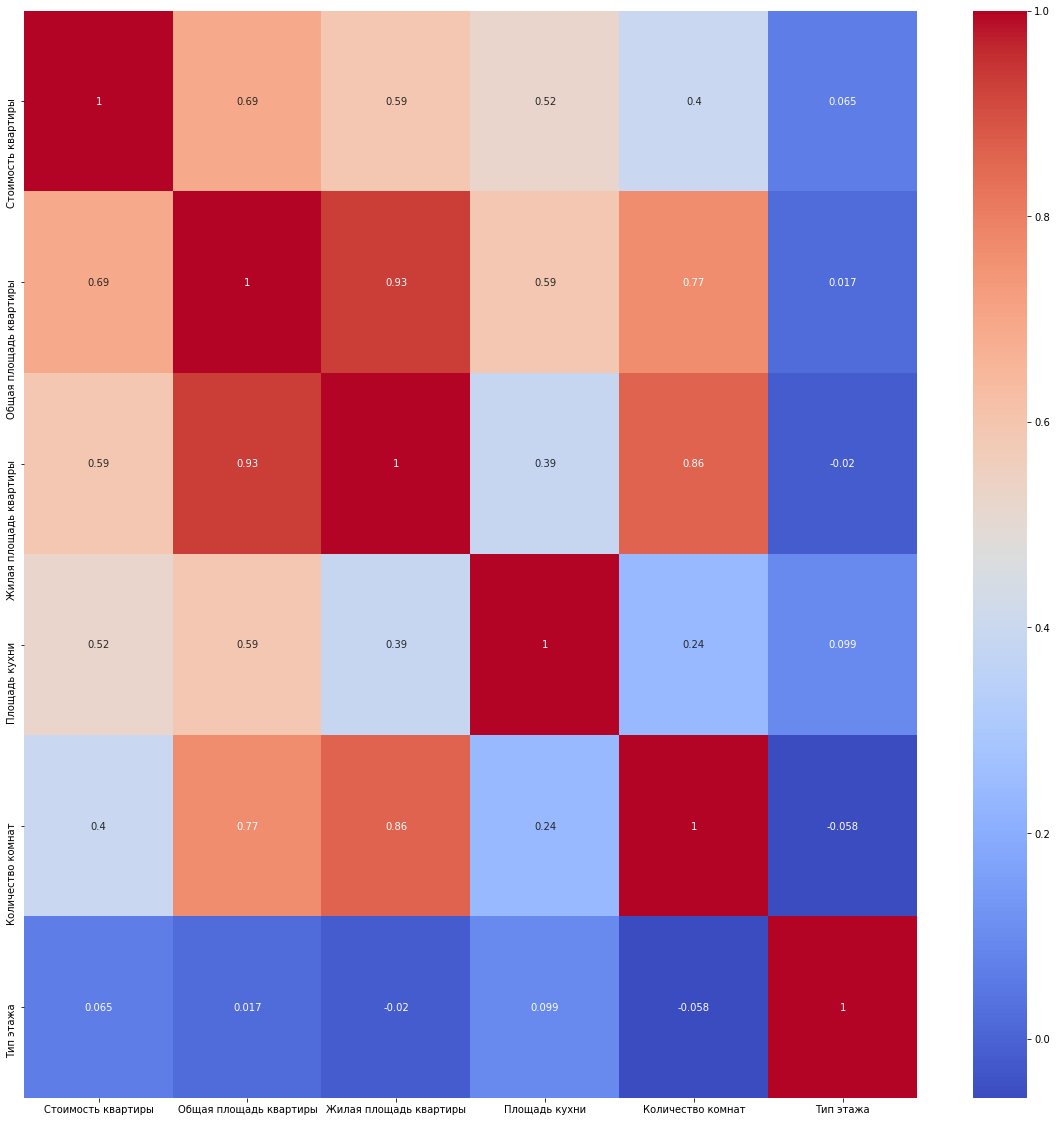

In [31]:
data['floor_category_number'] = data['floor_category'].map({'первый': 0, 'последний': 1, 'другой': 2})
# Список с параметрами для проверки
corr = ['last_price', 'total_area', 'living_area', 'kitchen_area', 'rooms', 'floor_category_number']
# Список с названиями параметров
corr_names = ['Стоимость квартиры','Общая площадь квартиры', 'Жилая площадь квартиры', 'Площадь кухни', 'Количество комнат', 'Тип этажа']
# Матрица корреляции
corr_matrix = data[corr].corr()
print(corr_matrix)
# Визуализируем данные с помощьб heatmap
plt.figure(figsize = (20, 20))
sns.heatmap(corr_matrix,
            cmap='coolwarm', annot=True,
            yticklabels=corr_names,
            xticklabels=corr_names)
plt.show()

На тепловой карте видно, что общая площадь квартиры, жилая площадь и площадь кухни больше всего влияют на конечную стоимость квартиры. Также видно, что стоимость квартиры сильно зависит от количества комнат.

<AxesSubplot:xlabel='last_price', ylabel='floor_category'>

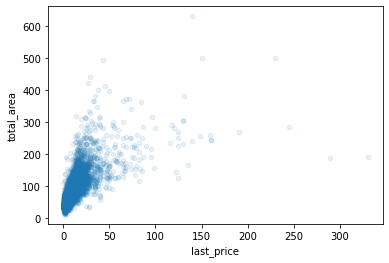

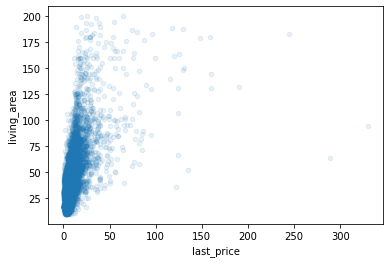

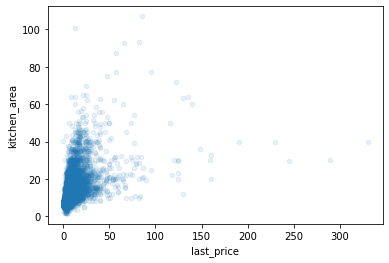

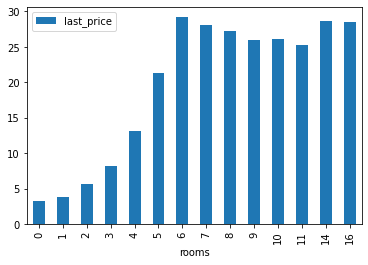

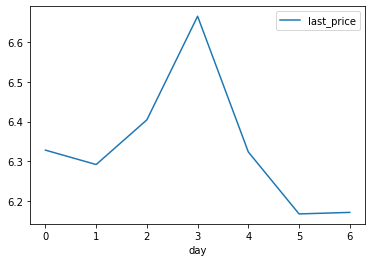

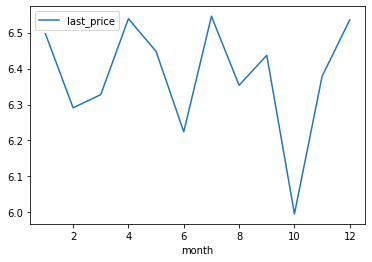

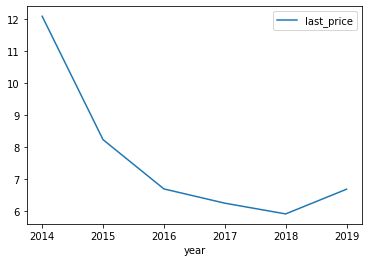

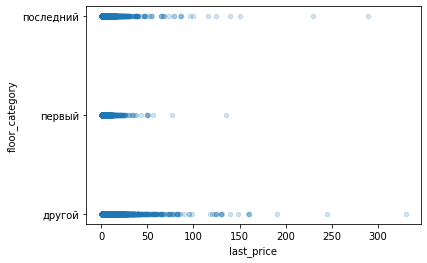

In [32]:
# Построим графики для дополнительной визуализации 
data.plot(x='last_price', y='total_area', kind='scatter', alpha=0.1)
data.plot(x='last_price', y='living_area', kind='scatter', alpha=0.1)
data.plot(x='last_price', y='kitchen_area', kind='scatter', alpha=0.1)
data.pivot_table(index='rooms',values='last_price').plot(y='last_price', kind='bar');
data.pivot_table(index='day',values='last_price',aggfunc='mean').plot(y='last_price', kind='line');
data.pivot_table(index='month',values='last_price',aggfunc='mean').plot(y='last_price', kind='line');
data.pivot_table(index='year',values='last_price',aggfunc='mean').plot(y='last_price', kind='line');
data.plot(x='last_price', y='floor_category', kind='scatter', alpha=0.2)


Вывод: 

Цена больше всего зависит от общей площади квартиры, далее идёт жилая площадь, площадь кухни, а также количество комнат.

От даты размещения и стоимость практически не зависит. На первом и последнем этажах стоимость квартиры меньше, чем на остальных.

<font size="+1">Посчитайте среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений. Выделите населённые пункты с самой высокой и низкой стоимостью квадратного метра. Эти данные можно найти по имени в столбце locality_name</font>  

In [33]:
# Посмотрим топ-10 населенных пунктов с наибольшим числом объявлений.
top_10 = data['locality_name'].value_counts().head(10)
print(top_10)

Санкт-Петербург      15620
поселок Мурино         555
поселок Шушары         439
Всеволожск             397
Пушкин                 365
Колпино                337
поселок Парголово      326
Гатчина                307
деревня Кудрово        299
Выборг                 235
Name: locality_name, dtype: int64


In [34]:
# Посмотрим среднюю цену за квадратный метр в топ-10 населённых пунктах
top_10 = data.query('locality_name in @top_10.index').pivot_table(index='locality_name', values='price_one_square_meter')
top_10.sort_values(by='price_one_square_meter', ascending=False)

,price_one_square_meter
locality_name,
Санкт-Петербург,114348.639886
Пушкин,103122.752511
деревня Кудрово,92473.547576
поселок Парголово,90205.423758
поселок Мурино,85653.613799
поселок Шушары,78703.263242
Колпино,75443.972838
Гатчина,68746.146763
Всеволожск,68719.320400


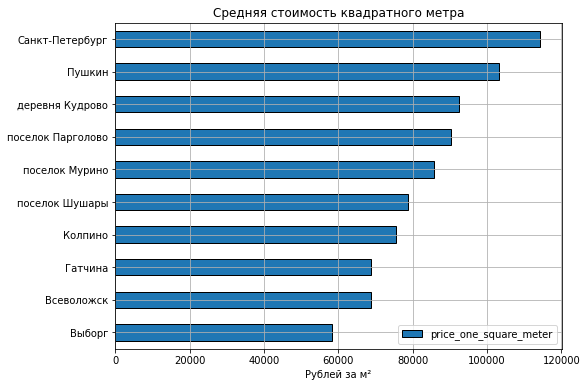

In [35]:
# Отобразим полученные данные на графике
top_10.sort_values(by='price_one_square_meter').plot(kind='barh',ec='black', figsize=(8, 6), grid=True)

plt.title('Средняя стоимость квадратного метра')
plt.xlabel('Рублей за м²')
plt.ylabel('')
plt.show()

Вывод:

Наибольшая стоимость одного квадратного метра - в Санкт-Петербурге, что логично. Далее идёт Пушкин (город в составе Санкт-Петербурга). 

Наименьшая стоимость одного квардратного метра - в Выборе, вероятно, связано с большой удалённостью от крупного города (примерно 120 км).

<font size="+1">Ранее вы посчитали расстояние до центра в километрах. Теперь выделите квартиры в Санкт-Петербурге с помощью столбца locality_name и вычислите среднюю цену каждого километра. Опишите, как стоимость объектов зависит от расстояния до центра города</font>

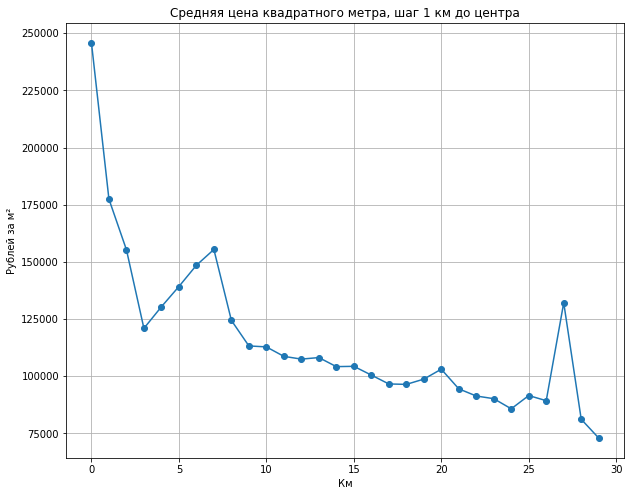

In [36]:
# Выбор населенного пункта Санкт-Петербург
data_saintp = data.query('locality_name == "Санкт-Петербург"')

(
data_saintp
    .pivot_table(index='cityCenters_nearest', values='price_one_square_meter')
    .plot(marker='o', grid=True, figsize=(10, 8), legend=False)
)
plt.title('Средняя цена квадратного метра, шаг 1 км до центра')
plt.xlabel('Км')
plt.ylabel('Рублей за м²')
plt.show()

Вывод:

По графику видно, что цена после 8-го километра от центра начинает снижаться, выброс на 27-ом километре может быть вызван стоимостью на элитную недвижимость.

### Общий вывод

Была проведена предобработка данных, включающая в себя: работу с пропусками, изменение типа данных, работу с дубликатами и выбросами.

В таблицу были добавлены столбцы с информацией о стоимости одного квадратного метра, днём, месяцем и годом публикации объявления, а также столбцы, где указан тип этажа квартиры и расстояние в км до центра города.

Определили, что наиболее влиятельным фактором для стоимости квартиры является её площадь, чем больше площадь, тем больше стоимость квартиры. Также на стоимость влияет количество комнат в квартире. Квартиры, расположенные ближе к центру города, стоят дороже, на расстоянии от 8 км и выше стоимость квартир снижается.

Топ 3 населенных пункта по стоимости квадратного метра, не включая Петербург:
1. Пушкин - примерно 100 тыс/руб. за кв.м.
2. Кудрово - примерно 93 тыс/руб. за кв.м.
3. Парголово - немного ниже, чем в Кудрово, примерно 90 тыс/руб за кв.м.

Топ 3 самых доступных населенных пункта по стоимости квадратного метра:
1. Выборг - примерно 60 тыс/руб. за кв.м.
2. Всеволожск - примерно 70 тыс/руб. за кв.м.
3. Гатчина - аналогично Всеволожску, примерно 70 тыс/руб. за кв.м.

Обычно квартиры продаются за 45 дней, быстрой считается продажа квартиры менее чем за 95 дней, а долгой - более чем за 180 дней.